In [1]:
import numpy as np
from torch import nn
from torch import optim

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, test_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
import lib.torch_device as tdev
import torch.optim.lr_scheduler as lr_scheduler

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69421)

In [4]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

correlated_columns_to_drop = array([  0,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214

In [5]:
data_train.shape

(960, 100, 264)

In [6]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 264)
(60, 100)


## Hyper Parameters

In [7]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_train.shape[-1],
    out_features=NUM_CLASSES,
    
    self_attention=True,
    d_model=60,
    num_heads=12,
    stack_size=1,
    dropout=0.1,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[64],
    
    linear_activation_provider=lambda: nn.LeakyReLU(),
)

In [8]:
EPOCH_MULTIPLIER = 0.5

training_hyper_parameters = TrainingHyperParameters(
    batch_size=32,
    
    optimizer_provider=lambda model, lr: optim.Adamax(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.98),
        eps=1e-9
    ),
    
    num_epochs=int(100 * EPOCH_MULTIPLIER),
    lr=1e-2,
    lr_scheduler_provider=lambda optimizer: lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[int(m * EPOCH_MULTIPLIER) for m in [8, 20, 50, 90]],
        gamma=0.5
    )
)

## Training

Training fold 0
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.8275,  9.6494, 10.6295, 36.9184, 17.7606, 19.8364],
       device='cuda:0')
Training Epoch 0  : lr = 0.010000, epoch_loss = 42.996504, num_correct =  9677, num_samples = 86400, acc = 0.112002, bacc = 0.288992
Evaluated with loss = 0.043177, acc = 0.232813, bacc = 0.551200
Training Epoch 1  : lr = 0.010000, epoch_loss = 25.908473, num_correct = 25948, num_samples = 86400, acc = 0.300324, bacc = 0.434562
Evaluated with loss = 0.099300, acc = 0.585000, bacc = 0.763922
Training Epoch 2  : lr = 0.010000, epoch_loss = 16.267985, num_correct = 44710, num_samples = 86400, acc = 0.517477, bacc = 0.547314
Evaluated with loss = 0.142157, acc = 0.653854, bacc = 0.804000
Training Epoch 3  : lr = 0.010000, epoch_loss = 10.737941, num_correct = 62149, num_samples = 86400, acc = 0.719317, bacc = 0.624732
Evaluated with loss = 0.107801, acc = 0.694688, bacc = 0.826991
Training Epoch 4  : lr = 0.005000, 

KeyboardInterrupt: 

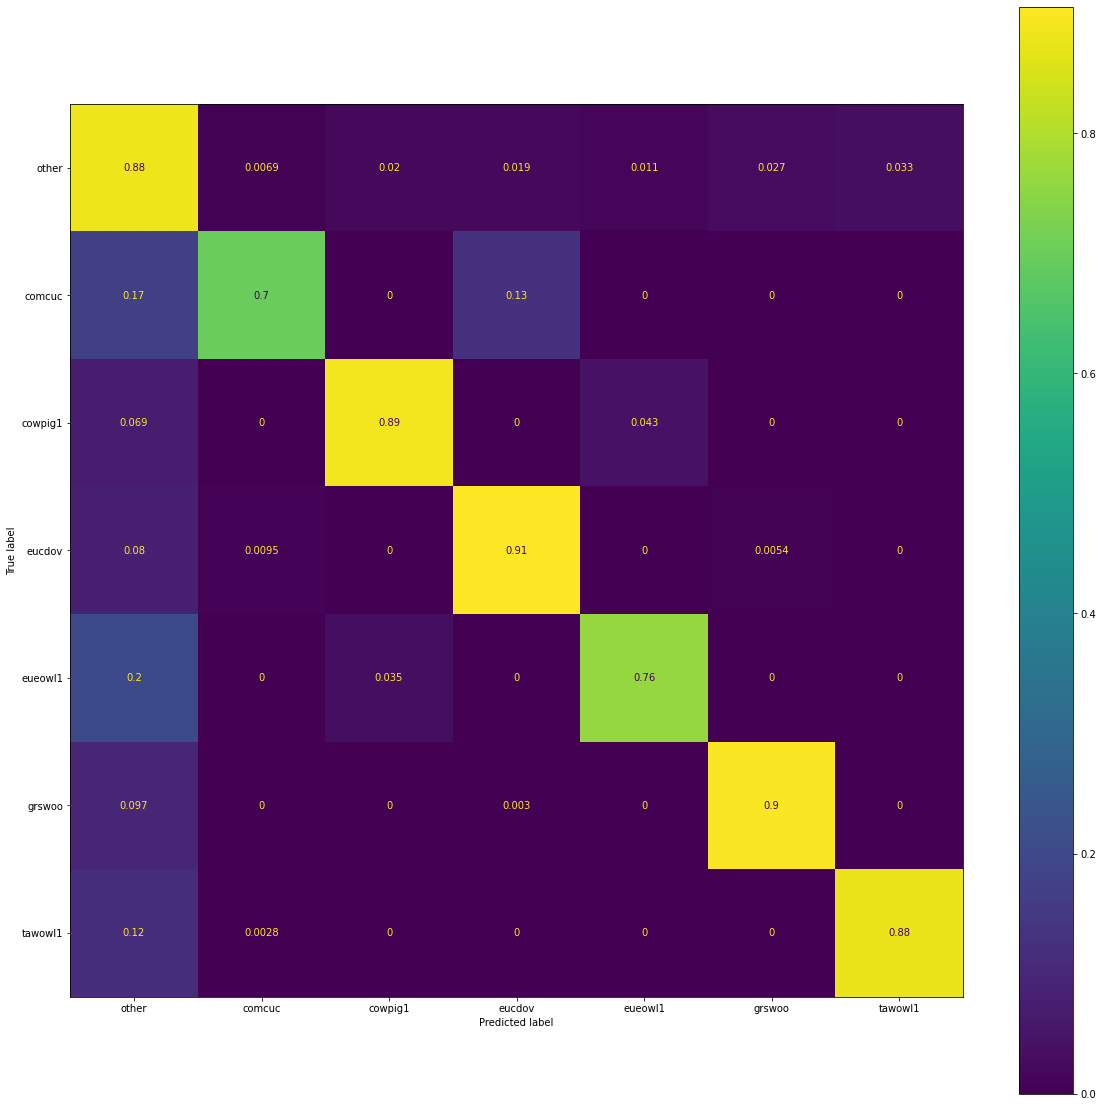

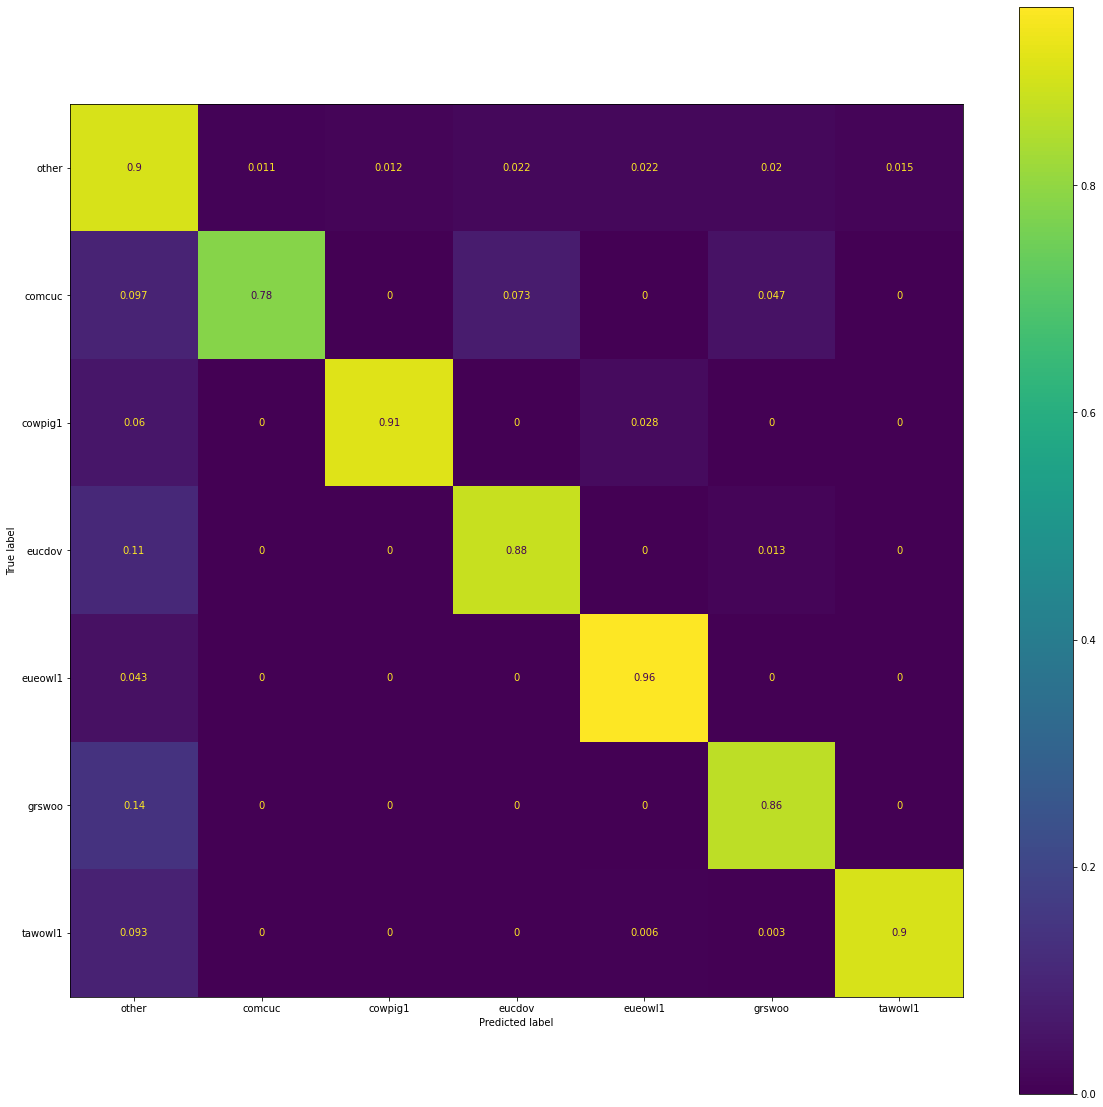

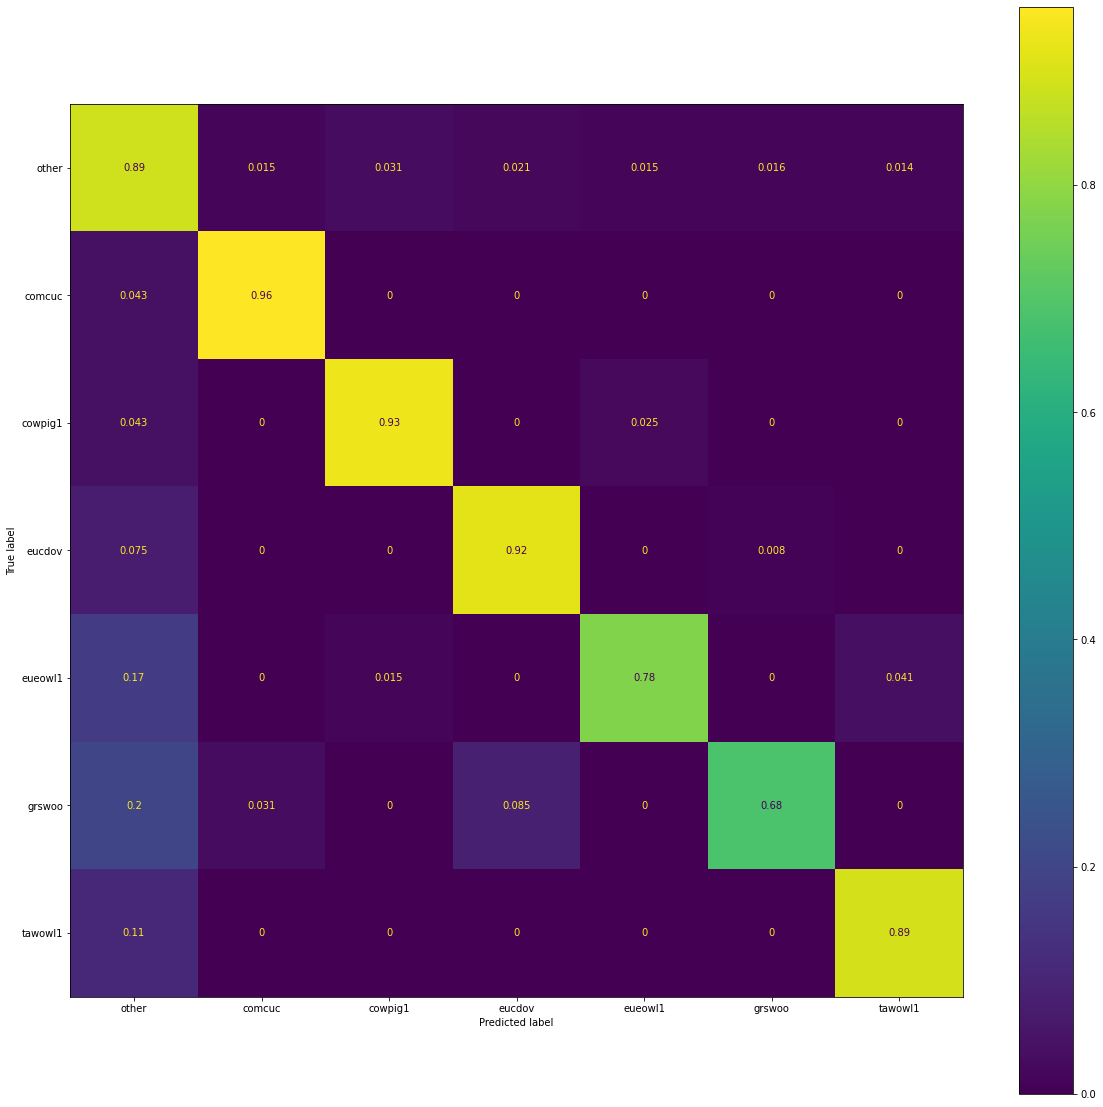

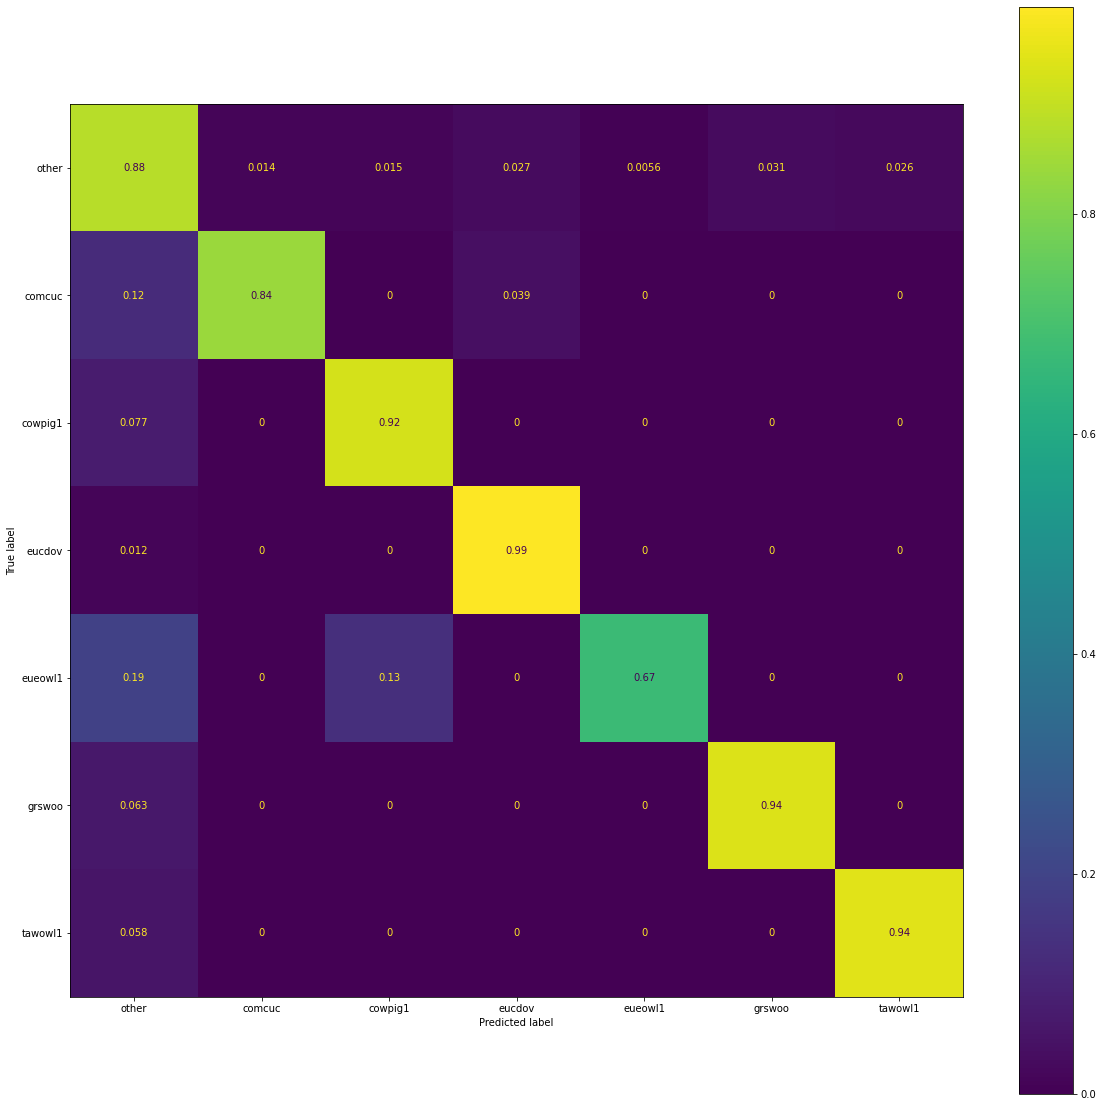

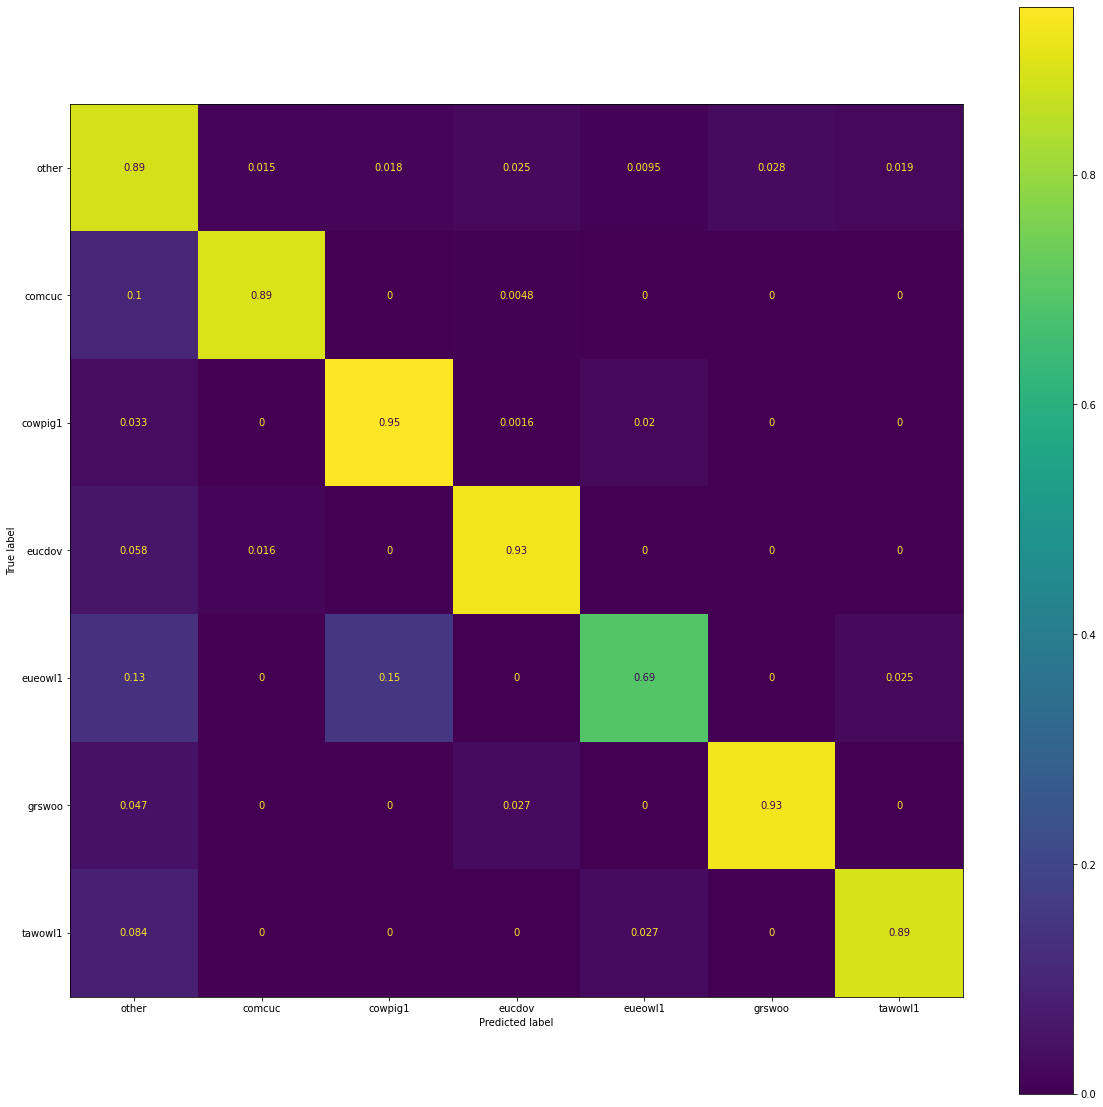

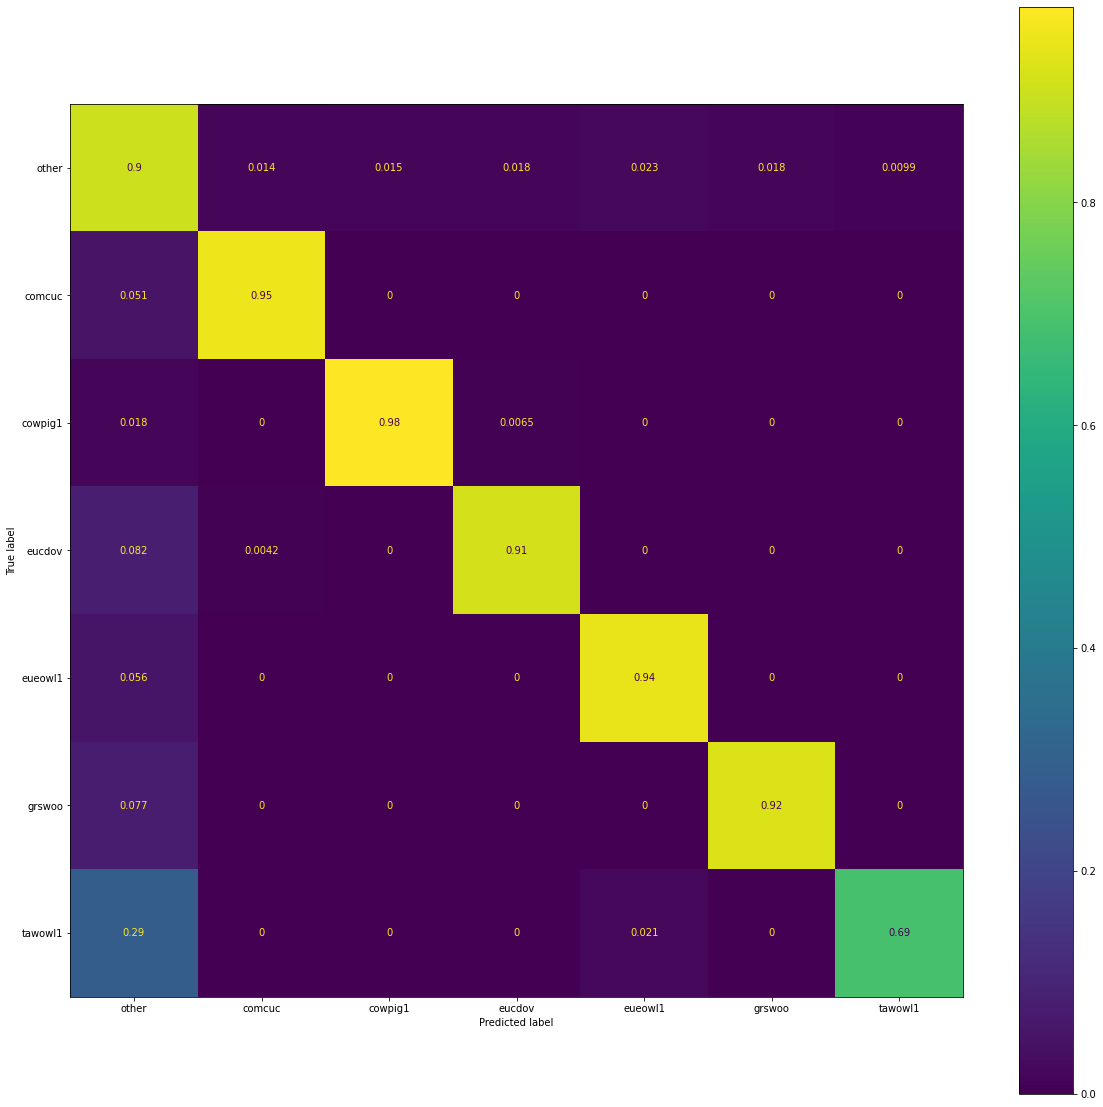

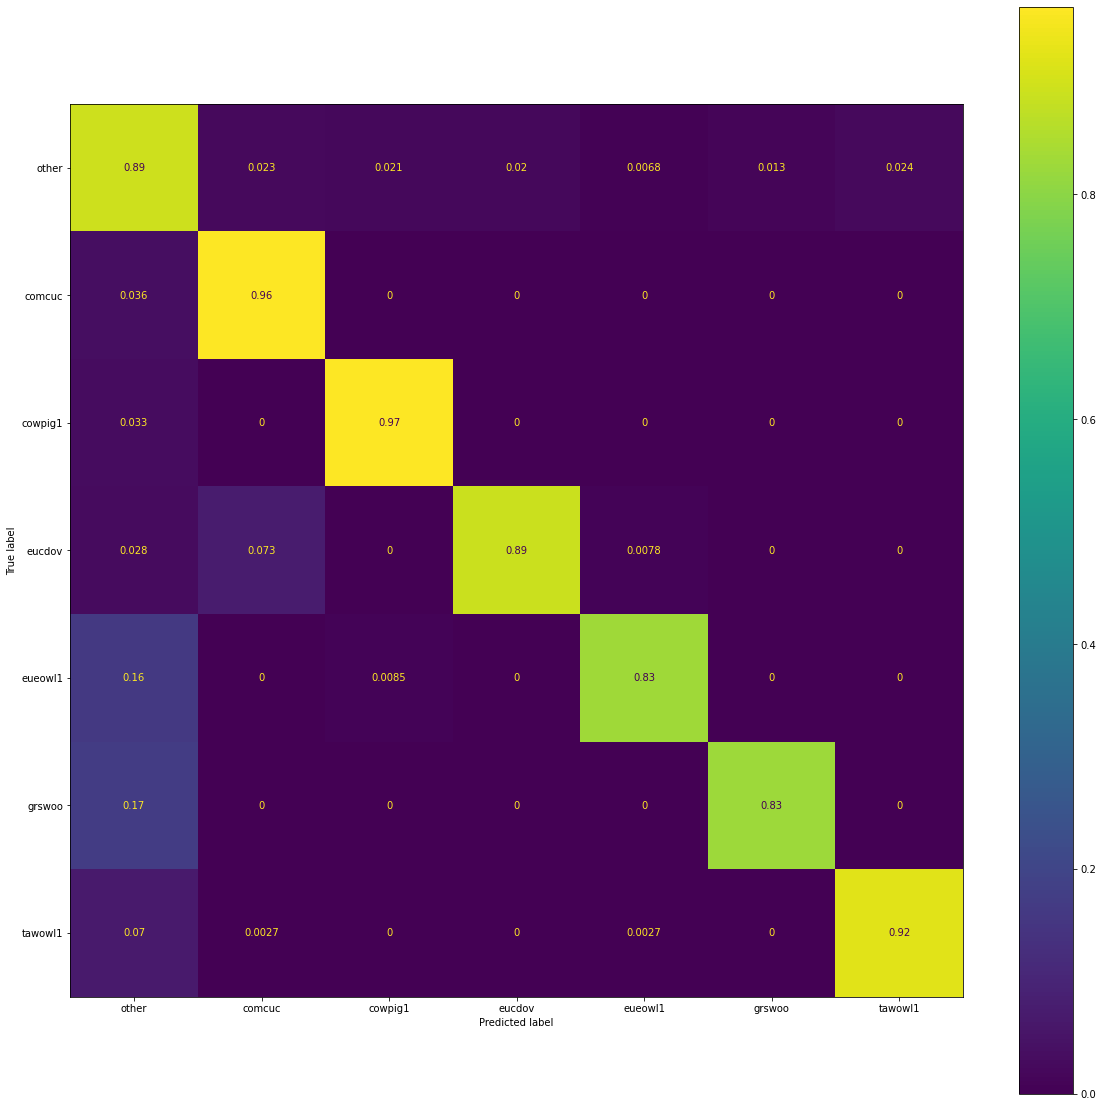

In [50]:
set_random_seed(42)

cv_models = train_attention_classifier_with_cv(
    hyper_parameters, 
    training_hyper_parameters, 
    NumpyDataset(data_train, labels_train),
    device
)

Evaluated with loss = 0.000180, acc = 0.843542, bacc = 0.851831


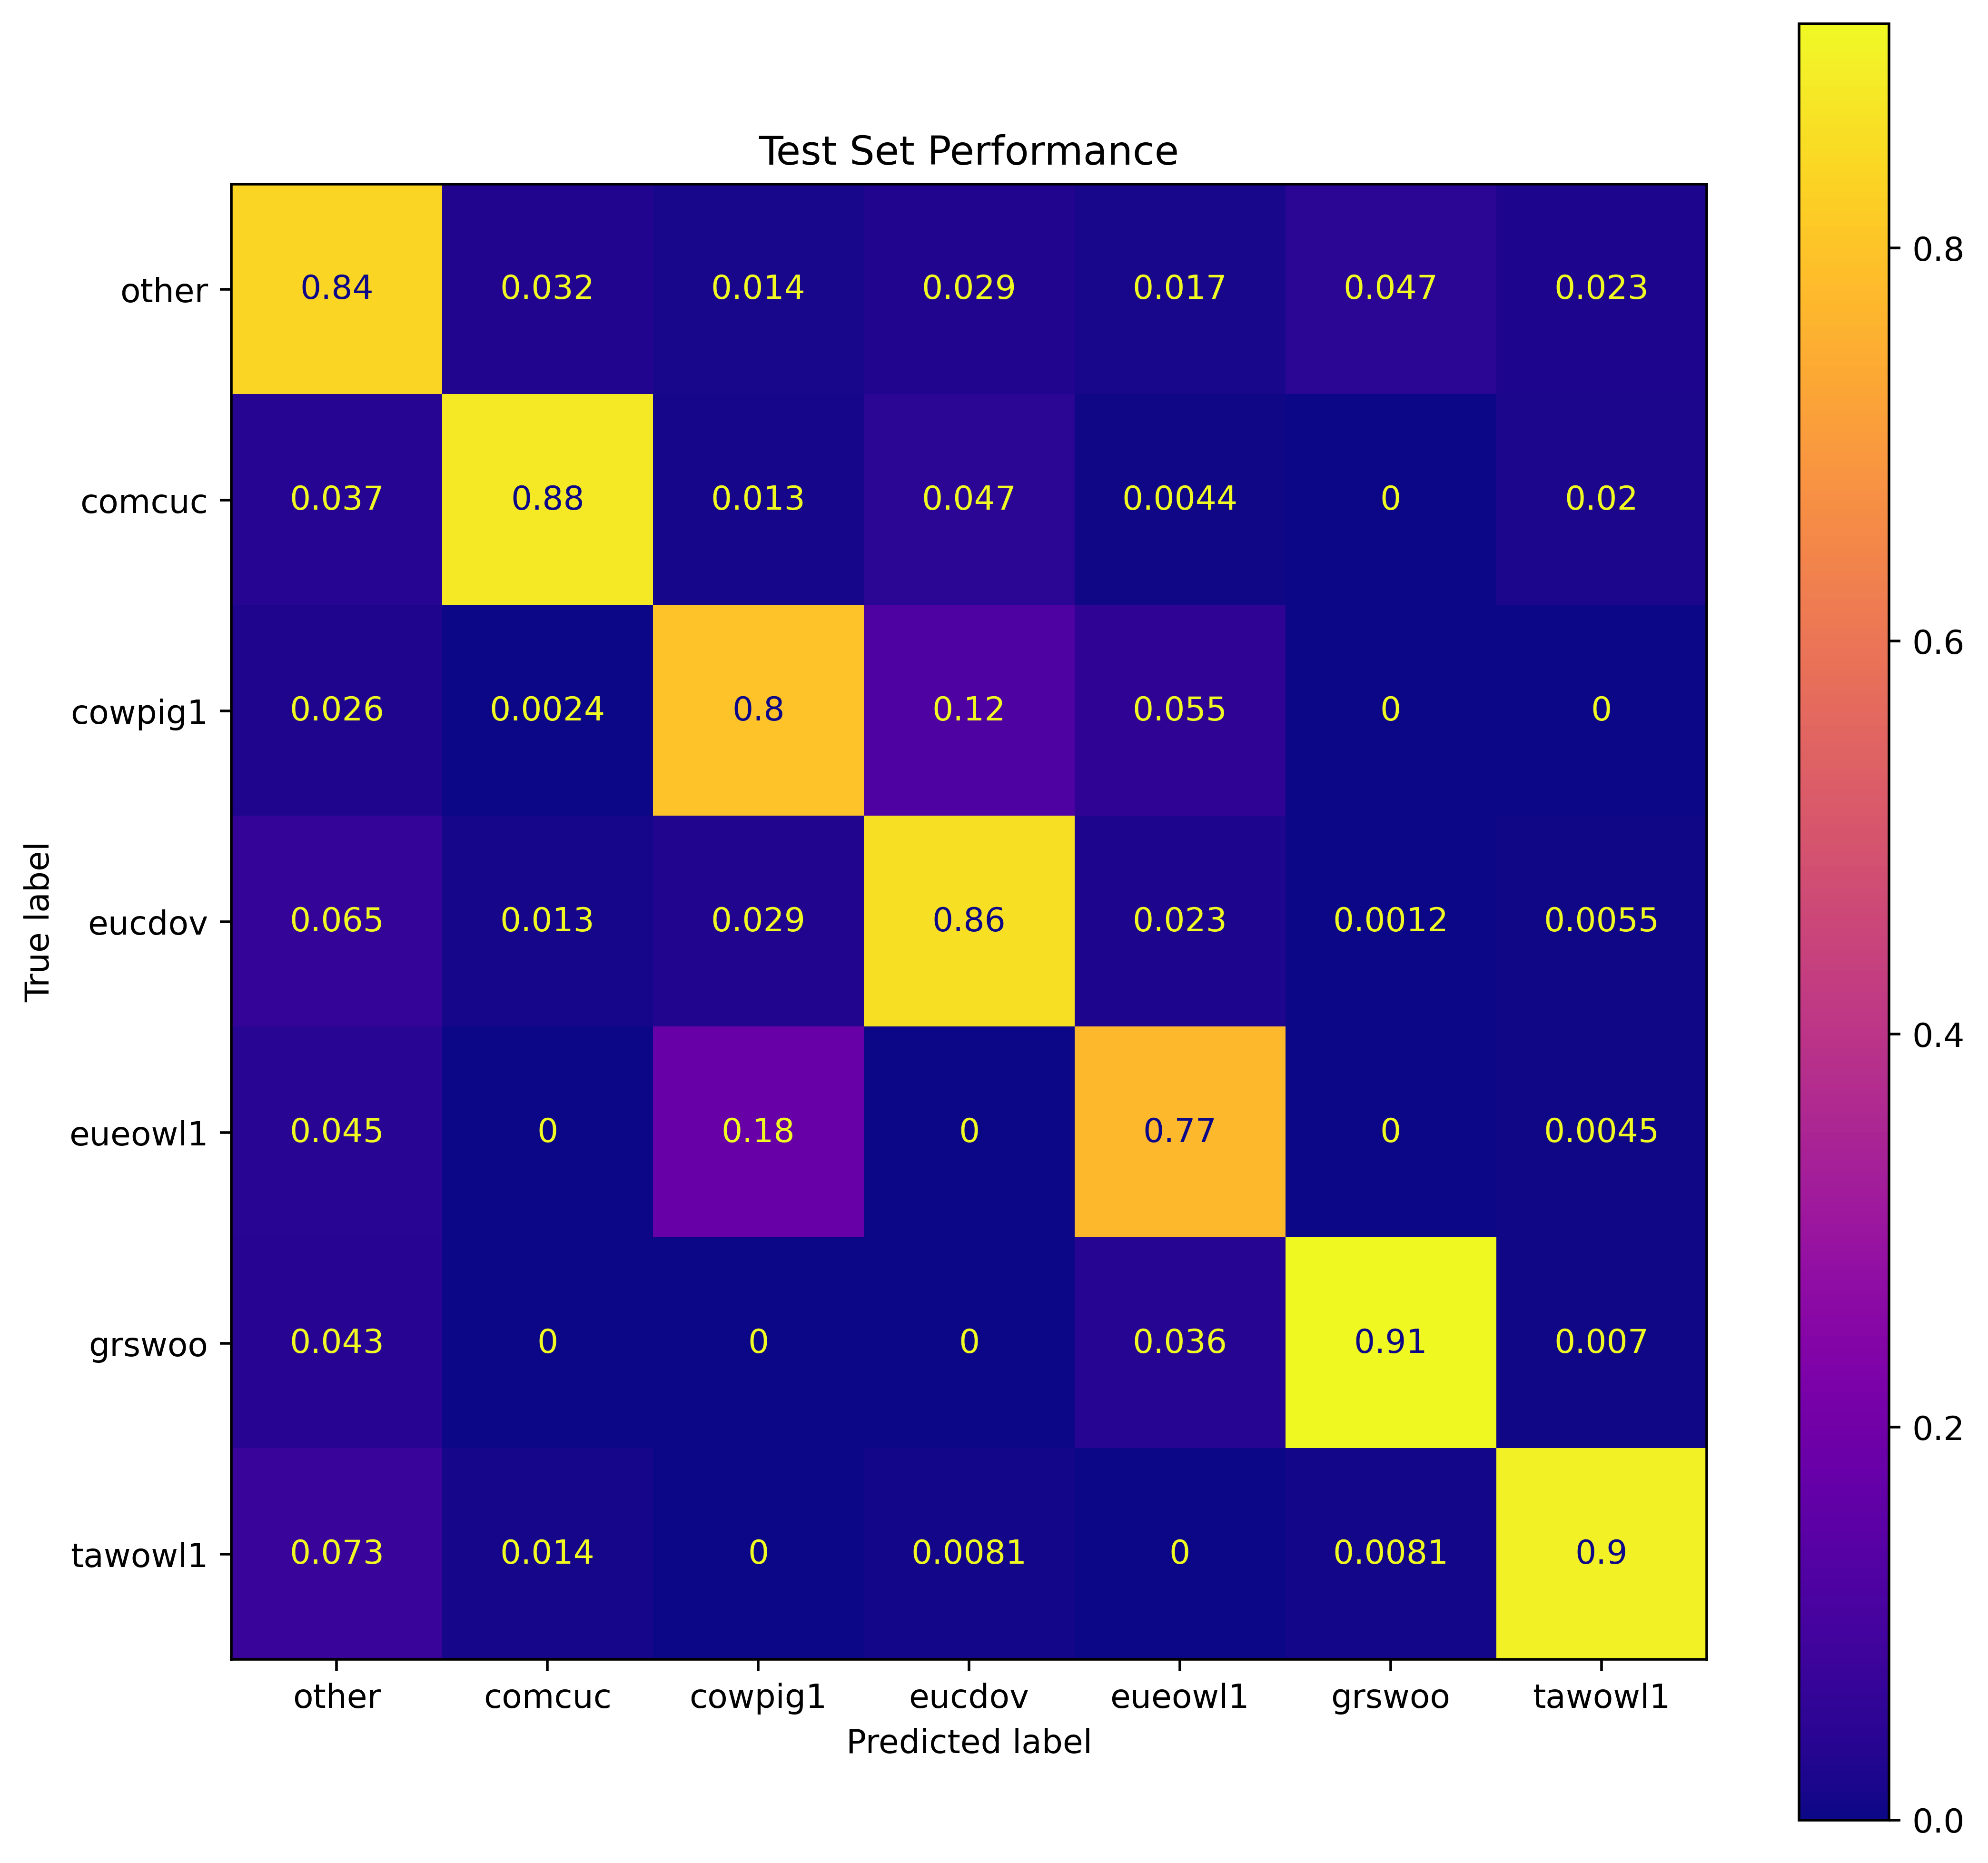

In [12]:
set_random_seed(42)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

# attention_classifier = train_attention_classifier(
#     hyper_parameters, 
#     training_hyper_parameters, 
#     NumpyDataset(data_train_normalized, labels_train),
#     NumpyDataset(data_test_normalized, labels_test),
#     device
# )

# test_loader = create_data_loader(np.random.normal(size=(240, 100, 268)), np.random.randint(0, 7, size=(240, 100)))
test_loader = create_data_loader(data_test_normalized, labels_test)
test_attention_classifier(
    attention_classifier, 
    test_loader, 
    device, 
    show_confmat = True,
    confmat_title = 'Test Set Performance'
)

In [48]:
# save_model(attention_classifier, 'attention_classifier bacc-0.856688')

'saved_models\\attention_classifier bacc-0.856688.pt'

In [35]:
# load_model('attention_classifier fold-1')
# TODO: normalization
test_loader = create_data_loader(data_test_normalized, labels_test)
test_attention_classifier(load_model('cv1/attention_classifier fold-0'), test_loader, device)

NameError: name 'data_test_normalized' is not defined